# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: May 1, 2023
* Student Name: Sarah Elmasry
* Student Net ID: sme5qyx
* This URL: <a URL to the notebook source of this document>
* GitHub Repo URL: https://github.com/sasa793/montecarlo_final

# The Monte Carlo Module

In [109]:
import pandas as pd
import numpy as np

class Die:
    """A die has N sides, or “faces”, and W weights, and can be rolled to select a face.W weights defaults to 1  for each face but can be changed after object is created. The die has one behavior, this is to be rolled one or more times. Includes 3 methods: change_weight, roll, and show_die."""
    
    def __init__(self, faces):
        """Takes an array of faces as an argument and internally initalizes the weights to 1.0 for each face. Both faces and weights are saved into a private dataframe that is to be shared with other methods"""
        self.faces = faces
        self.weights = [1.0] * len(self.faces)
        self._df = pd.DataFrame({'faces': self.faces, 'weights': self.weights})
        
    def change_weight(self, face, weight):
        """This method changes the weight of a single side. Two arguments are taken, the face value to be changed and the new weight. It checks to see if the face passed is a valid array of weights and if the weight is valid/a float or convertible to a float."""
        if face not in self.faces:
            print("Error: {face} is not a valid face value.")
            return
        try:
            float(weight)
        except ValueError:
            print("Error: weight must be a float.")
            return
        index = self._df.index[self._df['faces'] == face]
        self._df.at[index, 'weights'] = weight

    def roll(self, n=1):
        """This is a random sample from the vector of faces according to the weights that returns a list of outcomes that's not stored internally. It takes a parameter for how many times the die is rolled but efaults to 1."""
        results = []
        norm_weights = np.array(self.weights)/sum(self.weights)
        for i in range(n):
            result = np.random.choice(self.faces, p=norm_weights)
            results.append(result)
        return results
    
    def show_die(self):
        """This method shows the user the die's current set of faces and weights in a dataframe."""
        return self._df

    
class Game:
    """Where one or more die of the same kind one or more time where the games are initalized with one or more similarly defined dice objects. By “same kind” and “similarly defined” we mean that each die in a given game has the same number of sides and associated faces, but each die object may have its own weights.The most recent play results are kept in the class. Includes 2 methods: play and show (narrow or wide)"""
    
    def __init__(self, dice):
        """Takes a single parameter, a list of already instantiated similar Die objects."""
        self.dice = dice
        self._results = pd.DataFrame()
        
    def play(self, n_rolls):
        """Takes a parameter to specify how many times the dice should be rolled, the results are then saved to a private dataframe of shape N rolls by M dice. The roll number is a named index. The results table containing data has a column for roll number, die number (it's list index), and the face rolled in that instance. """
        for index, die in enumerate(self.dice):
            self._results[index+1] = die.roll(n_rolls)

    def show_results(self, form = 'wide'):
        """This method passes the private dataframe to the user where a parameter is taken to return the dataframe in narrow or wide form. Narrow has a two column index with the roll and die number, and a column of face rolled. While the wide dataframe will have a single column index with the roll number and each die number as a column."""
        if form == 'wide':
            return self._results

        elif form == 'narrow':
            return self._results.melt(var_name='Die', value_name='Value')
        
        else:
            raise ValueError("Wrong result type")
           
        
class Analyzer:
    """This class takes the results of a single game and computes various descriptive statistical properties about it. These properties results are available as attributes of an Analyzer object. Includes 3 methods: jackpot, combo, and face_counts_per_roll"""
    
    def __init__(self, game):
        """Takes a game object as its input parameter. At initialization time, it also infers the data type of the die faces used."""
        self.game = game
        self.face_type = type(game.dice[0].faces[0])
        self.combos_df = pd.DataFrame()
        self.counts_df = pd.DataFrame()
    
    def jackpot(self):
        """Demonstrates how many times the game resulted in all faces being identical and returns that number to the user as an integer. The dataframe of results, containing roll number as a named index, are stored as a public attribute."""
        return (self.game.show_results(form='wide').nunique(axis=1) == 1).sum()
    
    def combo(self):
        """Computes how many times the distinct combination of faces are rolled along with their counts. These combinations are sorted and saved as a multi-columned index. The results are stored as a dataframe in a public attribute."""
        sorted_rolls = self.game.show_results(form='wide').apply(lambda row: tuple(sorted(row)), axis=1)
        self.combos_df = sorted_rolls.value_counts().reset_index(name='counts').set_index("index")
        self.combos_df = self.combos_df.sort_values(by='counts', ascending=False)
    
    def face_counts_per_roll(self):
        """Computes how often a given face is rolled in each event. The results are storred as a dataframe in a public attribute. Said dataframe has an index of the roll number and face values as columns(wide form)"""
        faces = sorted({face for die in self.game.dice for face in die.faces})
        
        self.counts_df = pd.DataFrame(index=self.game.show_results(form='wide').index, columns=faces)
        self.counts_df = self.counts_df.fillna(0)
        
        for i, row in self.game.show_results(form='wide').iterrows():
            row_counts = row.value_counts()
            self.counts_df.loc[i, row_counts.index] = row_counts.values

# Test Module

In [ ]:
import numpy as np
import pandas as pd
import unittest
from montecarlo import Die, Game, Analyzer

class MonteCarloTestSuite(unittest.TestCase):
    
    
    def test_die_created(self):
        """Tests to determine that all the present die faces has a weight of 1.0"""
        my_die = Die([1, 2, 3, 4])
        expected = [1.0, 1.0, 1.0, 1.0]
        actual= list(my_die._df.weights)
        self.assertEqual(expected, actual)
        
    
    def test_change_weight(self):
        """Tests to see if the weight was correctly changed for the specified die face"""
        my_die = Die([1, 2, 3, 4, 5, 6])
        my_die.change_weight(5, 7.5)
        expected = 7.5
        actual = my_die.show_die().iloc[4]['weights']
        self.assertEqual(expected,actual)
      
        
    def test_roll(self):
        """Tests to see if the roll method works and outputs the correct value"""
        my_die = Die([1, 2, 3, 4, 5, 6])
        dtest = my_die.roll(2)
        self.assertEqual(len(dtest),2)
       
        
    def test_show_die(self):
        """Tests to see if df created has the right dimensions"""
        my_die = Die([1, 2, 3, 4, 5, 6])
        test_value = my_die.show_die().shape == (6, 2)    
        message = "Error: Incorrect dimensions of die df."    
        self.assertTrue(test_value, message)

        
    def test_play_game(self):
        """Tests the play method to assess whether the corrrect number of columns and rows are made"""
        my_dice1= Die([1, 2, 3, 4, 5, 6])
        my_dice2= Die([7, 8, 9, 10, 11, 12])
        my_game = Game([my_dice1, my_dice2])   
        my_game.play(5)
        vtest = my_game._results.shape == (5, 2)
        message = "Error: Incorrect data frame dimensions."
        self.assertTrue(vtest, message)        
        
    
    def test_show_results(self):
        """Tests to see if the show_results method defaults correctly (to the wide format)"""
        my_dice1= Die([1, 2, 3, 4, 5, 6])
        my_dice2= Die([7, 8, 9, 10, 11, 12])
        my_game = Game([my_dice1, my_dice2])
        my_game.play(5)
        expected = (5,2)
        actual = my_game.show_results().shape
        self.assertEqual(expected, actual)
        
        
    def test_jackpot(self):
        """Tests to see if the jackpots that the analyzer finds matches the jackpots count/jackpots actual hit. I created this forcing it to hit a certain amount"""
        my_dice1= Die([2, 2])
        my_dice2= Die([2, 2])
        my_game = Game([my_dice1, my_dice2])
        my_game.play(5)
        my_analyzer = Analyzer(my_game)
        tjackpot= my_analyzer.jackpot()
        self.assertTrue((tjackpot) == 5)
        
        
    def test_combo(self):
        """Tests the combo method of the analyzer class"""
        my_dice1= Die([1, 2, 3, 4])
        my_dice2= Die([1, 2, 3, 4])
        my_dice_list = [my_dice1, my_dice2]
        my_game = Game(my_dice_list)
        my_game.play(5)
        my_analyzer = Analyzer(my_game)
        my_analyzer.combo()
        tdf = my_analyzer.combos_df.size
        self.assertGreater(tdf, 0)
        
        
    def test_face_counts_per_roll(self):
        """Tests to see if the face counts df matches the correct shape for num of rolls and dice"""
        my_dice1= Die([1, 2, 3, 4])
        my_dice2= Die([1, 2, 3, 4])
        my_game = Game([my_dice1, my_dice2])
        my_game.play(5)
        my_analyzer = Analyzer(my_game)
        my_analyzer.face_counts_per_roll()    
        expected = (5, 4)
        actual = my_analyzer.counts_df.shape
        self.assertEqual(expected, actual)
        
    
if __name__ == "__main__":
    
    unittest.main(argv=['first-arg-is-ignored'], exit=False, verbosity=3)

# Test Results

In [70]:
!python montecarlo_test.py

test_change_weight (__main__.MonteCarloTestSuite)
Tests to see if the weight was correctly changed for the specified die face ... ok
test_combo (__main__.MonteCarloTestSuite)
Tests the combo method of the analyzer class ... ok
test_die_created (__main__.MonteCarloTestSuite)
Tests to determine that all the present die faces has a weight of 1.0 ... ok
test_face_counts_per_roll (__main__.MonteCarloTestSuite)
Tests to see if the face counts df matches the correct shape for num of rolls and dice ... ok
test_jackpot (__main__.MonteCarloTestSuite)
Tests to see if the jackpots that the analyzer finds matches the jackpots count/jackpots actual hit. I created this forcing it to hit a certain amount ... ok
test_play_game (__main__.MonteCarloTestSuite)
Tests the play method to assess whether the corrrect number of columns and rows are made ... ok
test_roll (__main__.MonteCarloTestSuite)
Tests to see if the roll method works and outputs the correct value ... ok
test_show_die (__main__.MonteCarloTes

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

In [71]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from montecarlo import Die, Game, Analyzer

## Scenario 1

**Create a fair coin (with faces H and T) and an unfair coin, in which one of the faces has a weight of 5 and the others 1.**

In [95]:
fair_coin = Die(['H', 'T'])
unfair_coin = Die(['H', 'T'])
unfair_coin.change_weight('T', 5)

**Play a game of 1000 flips with all fair dice.**

In [100]:
game_fair = Game([fair_coin, fair_coin, fair_coin])
game_fair.play(1000)

**Play a game of 1000 flips with 2 unfair fie and 1 fair.**

In [101]:
game_unfair = Game([fair_coin, unfair_coin, unfair_coin])
game_unfair.play(1000)

**For each game, use an Analyzer object to determine the relative frequency of jackpots – getting either all Hs or all Ts. Compute relative frequency as the number of jackpots over the total number of rolls.**

In [102]:
fair_analyzer = Analyzer(game_fair)
unfair_analyzer = Analyzer(game_unfair)                  
                  
fair_jack_freq = fair_analyzer.jackpot()/1000
unfair_jack_freq = unfair_analyzer.jackpot()/1000

**Show your results, comparing the two relative frequencies, in a simple bar chart.**

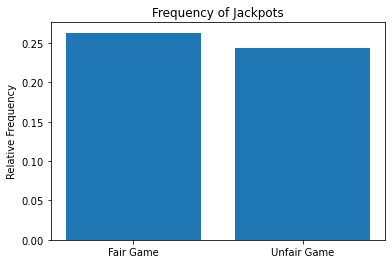

In [103]:
plt.bar(['Fair Game', 'Unfair Game'], [fair_jack_freq, unfair_jack_freq])
plt.ylabel('Relative Frequency')
plt.title('Frequency of Jackpots')
plt.show()

## Scenario 2

**Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will weight 1 five times more than the others.**

In [82]:
fair_die = Die([1,2,3,4,5,6])
unfair_die1 = Die([1,2,3,4,5,6])
unfair_die2 = Die([1,2,3,4,5,6])
unfair_die1.change_weight(6,5)
unfair_die2.change_weight(1,5)

**Play a game of 10000 rolls with 5 fair dice.**

In [83]:
die_game_fair = Game([fair_die, fair_die, fair_die, fair_die, fair_die])
die_game_fair.play(10000)

**Play a game of 10000 rolls with 2 unfair dice of type 1, 1 unfair die of type 2, and the rest fair dice.**

In [84]:
die_game_unfair = Game([unfair_die1, unfair_die1, unfair_die2, fair_die, fair_die])
die_game_unfair.play(10000)

**For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.**

Fair Jackpot 10
Unfair Jackpot 11


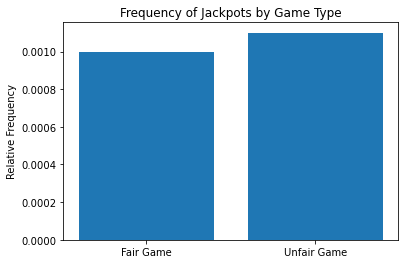

In [85]:
die_fair_analyzer = Analyzer(die_game_fair)
die_unfair_analyzer = Analyzer(die_game_unfair)   

print("Fair Jackpot", die_fair_analyzer.jackpot())
print("Unfair Jackpot", die_unfair_analyzer.jackpot())
                  
die_fair_jack_freq = die_fair_analyzer.jackpot()/10000
die_unfair_jack_freq = die_unfair_analyzer.jackpot()/10000

plt.bar(['Fair Game', 'Unfair Game'], [die_fair_jack_freq, die_unfair_jack_freq])
plt.ylabel('Relative Frequency')
plt.title('Frequency of Jackpots by Game Type')
plt.show()

**Also compute 10 most frequent combinations of faces for each game. Plot each of these as bar charts.**

<AxesSubplot:title={'center':'Unfair Game'}, xlabel='Combinations', ylabel='Counts'>

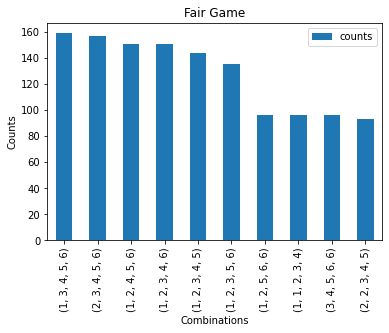

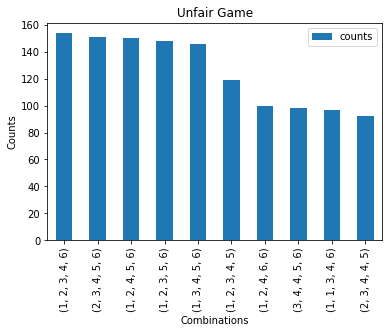

In [87]:
die_fair_analyzer.combo()
die_unfair_analyzer.combo()

Fair_die_combos = die_fair_analyzer.combos_df.head(10)
Fair_die_combos.plot.bar(title="Fair Game", xlabel='Combinations', ylabel='Counts')

Unfair_die_combos = die_unfair_analyzer.combos_df.head(10)
Unfair_die_combos.plot.bar(title="Unfair Game", xlabel='Combinations', ylabel='Counts')

## Scenario 3

**Create a "die" of letters from a to z with weights based on their frequency of usage.**

In [88]:
die_letters_ultimate = Die(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
die_letters_ultimate.weights = [8.4966, 2.0720, 4.5388, 3.3844, 11.1607, 1.8121, 2.4705, 3.0034, 7.5448, 0.1965, 1.1016, 5.4893, 3.0129, 6.6544, 7.1635, 3.1671, 0.1962, 7.5809, 5.7351, 6.9509, 3.6308, 1.0074, 1.2899, 0.2902, 1.7779, 0.2722]
die_letters_ultimate._df = pd.DataFrame({'faces': die_letters_ultimate.faces, 'weights': die_letters_ultimate.weights})

**Play a game involving 5 of these dice with 1000 rolls.**

In [89]:
die_letters = Game([die_letters_ultimate]*5)
die_letters.play(1000)

**How many combos can you find that are actual English words? NOTE: "combo" here just means resulting sequence, not literally combination as opposed to permutation.**

In [90]:
print(die_letters.show_results().head(50))

    1  2  3  4  5
0   E  C  E  L  N
1   R  M  E  C  U
2   O  A  B  E  T
3   I  N  C  T  O
4   L  O  O  H  R
5   N  O  B  E  C
6   R  A  R  H  T
7   C  U  E  E  A
8   E  F  A  W  N
9   H  Y  E  A  O
10  U  S  L  R  O
11  E  M  N  N  N
12  C  O  N  C  E
13  R  S  C  I  V
14  E  L  L  I  A
15  E  P  S  E  E
16  L  D  H  I  O
17  M  L  E  S  C
18  A  K  P  Q  I
19  N  I  K  I  E
20  O  N  B  R  R
21  D  E  A  R  R
22  O  Q  A  O  H
23  E  T  B  A  N
24  L  E  A  E  Y
25  S  E  O  T  E
26  R  D  E  B  C
27  R  C  N  F  B
28  R  B  E  I  R
29  R  N  O  F  C
30  Y  E  T  A  R
31  T  E  G  E  D
32  I  U  W  D  H
33  R  G  E  I  R
34  S  V  D  S  A
35  S  P  I  B  M
36  P  E  Z  I  A
37  E  R  M  C  N
38  C  L  S  A  D
39  N  P  N  L  R
40  M  P  L  N  A
41  I  I  P  U  R
42  A  A  D  T  N
43  N  H  A  P  A
44  I  L  W  S  P
45  T  O  R  H  E
46  S  A  H  P  G
47  N  N  E  R  O
48  P  H  S  F  P
49  T  E  Y  S  U


*After running this multiple times, I was not able to find any "combinations" that were actual english words. Therefore I did a bigger scope and looked at 50 assortments, none of which looked like english words.*

**Based on your eye count, what is the relative frequency of these words versus the rest?**

*Based on my eye count and what was stated above, for at least the first 50 rows, the relative frequency is zero.*

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [111]:
!ls -lRF -o

.:
total 112
-rw-r--r-- 1 sme5qyx  7048 May  1 19:25 LICENSE
drwxr-sr-x 4 sme5qyx  3072 May  2 17:10 montecarlo/
-rw-r--r-- 1 sme5qyx 76300 May  2 17:26 montecarlo_demo.ipynb
drwxr-sr-x 2 sme5qyx  2560 May  2 16:22 montecarlo.egg-info/
-rw-r--r-- 1 sme5qyx  1300 May  2 16:38 montecarlo_test_results.txt
-rw-r--r-- 1 sme5qyx   648 May  2 17:20 README.md
-rw-r--r-- 1 sme5qyx   482 May  2 17:10 setup.py

./montecarlo:
total 32
-rw-r--r-- 1 sme5qyx   43 May  2 16:09 __init__.py
-rw-r--r-- 1 sme5qyx  272 May  2 16:35 __init__.pyc
-rw-r--r-- 1 sme5qyx 6013 May  2 16:09 montecarlo.py
-rw-r--r-- 1 sme5qyx 3798 May  2 17:10 montecarlo_test.py
drwxr-sr-x 2 sme5qyx 1024 May  2 16:32 __pycache__/

./montecarlo/__pycache__:
total 16
-rw-r--r-- 1 sme5qyx  250 May  2 16:32 __init__.cpython-38.pyc
-rw-r--r-- 1 sme5qyx 7032 May  2 16:32 montecarlo.cpython-38.pyc

./montecarlo.egg-info:
total 20
-rw-r--r-- 1 sme5qyx   1 May  2 16:22 dependency_links.txt
-rw-r--r-- 1 sme5qyx 339 May  2 16:22 PKG-INFO
-rw-

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [112]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sfs/qumulo/qhome/sme5qyx/Documents/MSDS/DS5100/montecarlo_final
  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 1.0.0
    Uninstalling montecarlo-1.0.0:
      Successfully uninstalled montecarlo-1.0.0
  Running setup.py develop for montecarlo
